In [94]:
# Light GBM for Avito Demand Prediction Challenge
# Uses Bag-of-Words, meta-text features, and dense features.
# NO COMPUTER VISION COMPONENT.

# https://www.kaggle.com/c/avito-demand-prediction
# By Nick Brooks, April 2018

import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
# print("Data:\n",os.listdir("../input"))

# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
print("\nData Load Stage")
training = pd.read_csv('../train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing = pd.read_csv('../test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing.index
y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))


Data Load Stage
Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns


In [96]:
print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [97]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(-999,inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date","image"],axis=1,inplace=True)

Feature Engineering

Create Time Variables


In [98]:
print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1"]
print("Encoding :",categorical)

# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col] = lbl.fit_transform(df[col].astype(str))
    
print("\nText Features")

# Feature Engineering 
df['text_feat'] = df.apply(lambda row: ' '.join([
    str(row['param_1']), 
    str(row['param_2']), 
    str(row['param_3'])]),axis=1) # Group Param Features
df.drop(["param_1","param_2","param_3"],axis=1,inplace=True)

# Meta Text Features
textfeats = ["description","text_feat", "title"]
for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('nicapotato') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words


Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1']

Text Features


In [99]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":True
}
def get_col(col_name): return lambda x: x[col_name]
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=10000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('text_feat',CountVectorizer(
            ngram_range=(1, 2),
            max_features=10000,
            preprocessor=get_col('text_feat'))),
        ('title',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=10000,
            preprocessor=get_col('title')))
    ])


[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [100]:
start_vect=time.time()
vectorizer.fit(df.loc[traindex,:].to_dict('records'))
ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 9.46 Minutes


In [101]:
# # Dense Features Correlation Matrix
# f, ax = plt.subplots(figsize=[10,7])
# sns.heatmap(pd.concat([df.loc[traindex,[x for x in df.columns if x not in categorical]], y], axis=1).corr(),
#             annot=False, fmt=".2f",cbar_kws={'label': 'Correlation Coefficient'},cmap="plasma",ax=ax, linewidths=.5)
# ax.set_title("Dense Features Correlation Matrix")
# plt.savefig('correlation_matrix.png')

In [102]:
print("Modeling Stage")
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
gc.collect();

print("\nModeling Stage")

# Training and Validation Set
"""
Using Randomized train/valid split doesn't seem to generalize LB score, so I will try time cutoff
"""
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.20, random_state=1)

Modeling Stage
1503424 Rows and 24686 Cols
508438 Rows and 24686 Cols
Feature Names Length:  24686

Modeling Stage


In [114]:
print(ready_df[0])

  (0, 4597)	0.3403584205364966
  (0, 4733)	0.3898877926542901
  (0, 4758)	0.31661673714737343
  (0, 6562)	0.32825620150320367
  (0, 8026)	0.35624075860783777
  (0, 8215)	0.41786489459821274
  (0, 9504)	0.22944178468892956
  (0, 9514)	0.4122902883280193
  (0, 11560)	2.0
  (0, 11561)	1.0
  (0, 13838)	1.0
  (0, 13839)	1.0
  (0, 13865)	1.0
  (0, 13866)	1.0
  (0, 20005)	0.6656343706416807
  (0, 23273)	0.7462780209951606


In [121]:
print(ready_df[1])

  (0, 5589)	0.6398635116373566
  (0, 8621)	0.7684885727680735
  (0, 11560)	2.0
  (0, 11561)	1.0
  (0, 12977)	1.0
  (0, 12978)	1.0
  (0, 21592)	0.6629377100927764
  (0, 23475)	0.7486745571588139


In [122]:
print(ready_df[2])

  (0, 1332)	0.27903992786267057
  (0, 2879)	0.38662800743817327
  (0, 3762)	0.3989940844696657
  (0, 5125)	0.4215464121043569
  (0, 7229)	0.22777859702280626
  (0, 8186)	0.4106535810163463
  (0, 8341)	0.12949143891946827
  (0, 8765)	0.331942913346485
  (0, 8915)	0.17341668934341412
  (0, 9475)	0.1681735063785332
  (0, 9478)	0.172998802871137
  (0, 10428)	1.0
  (0, 10429)	1.0
  (0, 10791)	1.0
  (0, 10792)	1.0
  (0, 11560)	2.0
  (0, 11561)	1.0
  (0, 11836)	1.0
  (0, 11837)	1.0
  (0, 12726)	1.0
  (0, 12727)	1.0
  (0, 13801)	1.0
  (0, 13802)	1.0
  (0, 17222)	1.0


In [123]:
print(ready_df[3])

  (0, 4221)	0.9209781543391312
  (0, 6936)	0.3896142184649932
  (0, 11560)	2.0
  (0, 11561)	1.0
  (0, 12481)	1.0
  (0, 12482)	1.0
  (0, 13255)	1.0
  (0, 13256)	1.0
  (0, 17846)	1.0


In [124]:
print(ready_df[4])

  (0, 2104)	0.5650713032598241
  (0, 2108)	0.6367100889396529
  (0, 8786)	0.5246853198582014
  (0, 10068)	1.0
  (0, 11303)	1.0
  (0, 11315)	1.0
  (0, 12701)	1.0
  (0, 12702)	1.0
  (0, 13875)	1.0
  (0, 13969)	1.0
  (0, 15050)	0.42838614557918914
  (0, 15117)	0.4395857478713303
  (0, 15123)	0.568421323128292
  (0, 18312)	0.326770194983359
  (0, 18322)	0.4397364206292542


In [126]:
ready_df.shape

(2011862, 24662)

In [116]:
X.shape

(1503424, 24686)

In [127]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1202739, 24686), (300685, 24686), (1202739,), (300685,))

In [111]:
traindex.shape[0]

1503424

In [108]:
ready_df[0:traindex.shape[0]]

<1503424x24662 sparse matrix of type '<class 'numpy.float64'>'
	with 41898934 stored elements in Compressed Sparse Row format>

In [80]:
X.row

array([      0,       0,       0, ..., 1503423, 1503423, 1503423],
      dtype=int32)

In [81]:
X.col

array([      0,       1,       2, ...,  705374, 1107133, 1107137],
      dtype=int32)

In [84]:
X.data

array([8.84270000e+05, 1.90000000e+01, 4.62000000e+02, ...,
       3.11925570e-01, 2.67965274e-01, 3.61274334e-01])

In [92]:
from scipy.sparse import csc_matrix

# Access `row`, `col` and `data` properties of coo matrix.
df_X = pd.DataFrame({'index': X.row, 'col': X.col})

In [93]:
df_X.shape

(82325341, 2)

In [128]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': -1,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 0,
    'n_jobs' : -1,
    'reg_rambda' :0.5
}  

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train,
                feature_name=tfvocab,
                categorical_feature = categorical)
lgvalid = lgb.Dataset(X_valid, y_valid,
                feature_name=tfvocab,
                categorical_feature = categorical)

# Go Go Go
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=20000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=500,
    verbose_eval=500
)

Light Gradient Boosting Regressor


/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	train's rmse: 0.222597	valid's rmse: 0.225372
[1000]	train's rmse: 0.219099	valid's rmse: 0.223397
[1500]	train's rmse: 0.217063	valid's rmse: 0.222527
[2000]	train's rmse: 0.215531	valid's rmse: 0.222003
[2500]	train's rmse: 0.21426	valid's rmse: 0.221657
[3000]	train's rmse: 0.213142	valid's rmse: 0.221397
[3500]	train's rmse: 0.212128	valid's rmse: 0.221188
[4000]	train's rmse: 0.211179	valid's rmse: 0.221021
[4500]	train's rmse: 0.210305	valid's rmse: 0.220896
[5000]	train's rmse: 0.20948	valid's rmse: 0.220782
[5500]	train's rmse: 0.208682	valid's rmse: 0.220683
[6000]	train's rmse: 0.207931	valid's rmse: 0.2206
[6500]	train's rmse: 0.20717	valid's rmse: 0.220518
[7000]	train's rmse: 0.206474	valid's rmse: 0.220456
[7500]	train's rmse: 0.205802	valid's rmse: 0.220404
[8000]	train's rmse: 0.205136	valid's rmse: 0.220348
[8500]	train's rmse: 0.204458	valid's rmse: 0.220294
[9000]	train's rmse: 0.203819	valid's rmse

Text(0.5,1,'Light GBM Feature Importance')

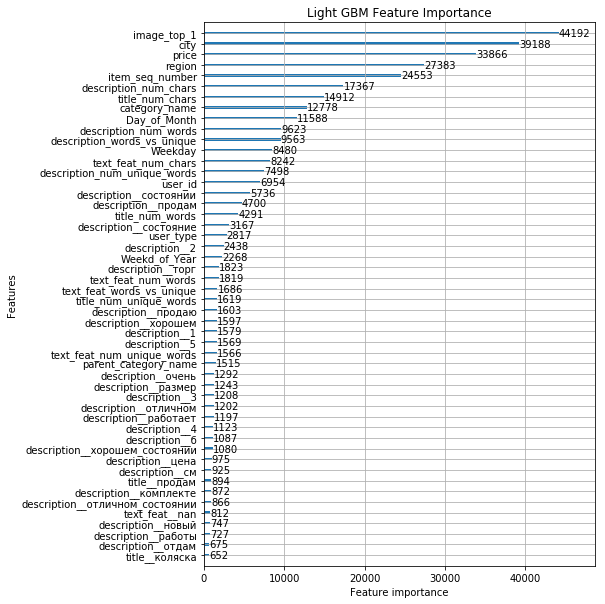

In [129]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [130]:
# print("Model Evaluation Stage")
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Model Runtime: 138.17 Minutes
Notebook Runtime: 173.69 Minutes


In [131]:
! kaggle competitions submit -c avito-demand-prediction -f lgsub.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge

In [133]:
gc.collect()

0

# feature selection

In [36]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1353081, 1186566), (150343, 1186566), (1353081,), (150343,))

In [37]:
model = lgb.LGBMRegressor().fit(X_train, y_train)

In [39]:
y_temp = model.predict(X_valid)

In [40]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid))))

RMSE: 0.2287721218248152


In [45]:
from sklearn.feature_selection import SelectFromModel

X_temp = SelectFromModel(model, prefit=True, threshold=1).transform(X)
testing_temp = SelectFromModel(model, prefit=True, threshold=1).transform(testing)
X_temp.shape, y.shape, testing_temp.shape

((1503424, 680), (1503424,), (508438, 680))

In [46]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y, test_size=0.20, random_state=1)

In [50]:
print("Light Gradient Boosting Regressor")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': -1,
    'num_leaves': 37,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    # 'bagging_freq': 5,
    'learning_rate': 0.015,
    'verbose': 0,
    'n_jobs' : -1,
    'reg_rambda' :0.5
}  

# LGBM Dataset Formatting 
lgtrain = lgb.Dataset(X_train, y_train)
lgvalid = lgb.Dataset(X_valid, y_valid)

# Go Go Go
modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=16000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=200,
    verbose_eval=200
)

Light Gradient Boosting Regressor
Training until validation scores don't improve for 200 rounds.
[200]	train's rmse: 0.232007	valid's rmse: 0.232149
[400]	train's rmse: 0.228601	valid's rmse: 0.229074
[600]	train's rmse: 0.2269	valid's rmse: 0.227605
[800]	train's rmse: 0.225777	valid's rmse: 0.226669
[1000]	train's rmse: 0.224948	valid's rmse: 0.226021
[1200]	train's rmse: 0.224314	valid's rmse: 0.22558
[1400]	train's rmse: 0.223793	valid's rmse: 0.225265
[1600]	train's rmse: 0.223347	valid's rmse: 0.22503
[1800]	train's rmse: 0.222951	valid's rmse: 0.224844
[2000]	train's rmse: 0.222592	valid's rmse: 0.224689
[2200]	train's rmse: 0.222249	valid's rmse: 0.224557
[2400]	train's rmse: 0.22193	valid's rmse: 0.224443
[2600]	train's rmse: 0.221629	valid's rmse: 0.224344
[2800]	train's rmse: 0.221327	valid's rmse: 0.224247
[3000]	train's rmse: 0.221051	valid's rmse: 0.224174
[3200]	train's rmse: 0.220779	valid's rmse: 0.224103
[3400]	train's rmse: 0.220516	valid's rmse: 0.224029
[3600]	trai

Text(0.5,1,'Light GBM Feature Importance')

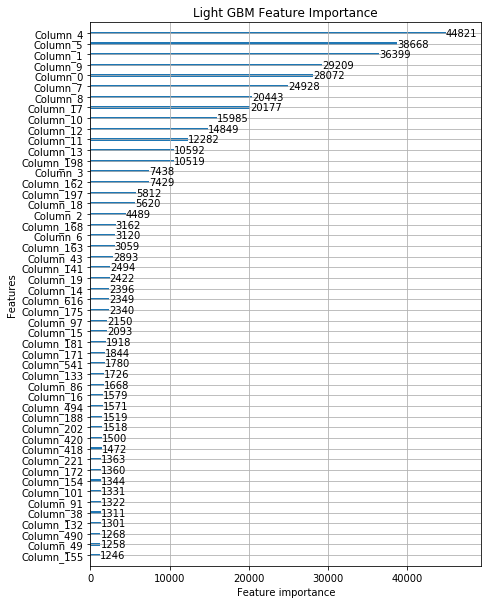

In [51]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")

In [52]:
print("Model Evaluation Stage")
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
lgpred = lgb_clf.predict(testing)
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub2.csv",index=True,header=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Model Evaluation Stage
RMSE: 0.22258603486194367


/home/jk/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Model Runtime: 28.20 Minutes
Notebook Runtime: 249.97 Minutes


In [55]:
! kaggle competitions submit -c avito-demand-prediction -f lgsub2.csv -m "Message"

Successfully submitted to Avito Demand Prediction Challenge